In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import ElasticNet
import logging
import sys
import json
import os
from datetime import datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap
import matplotlib.pyplot as plt

In [2]:
config_file = '../../configs/cancer_type/lgbm_grid_search_ic50_cancertype.json'
configs = json.load(open(config_file, 'r'))

In [3]:
seed = configs['seed']
cv = StratifiedKFold(n_splits=configs['cv'], shuffle=True, random_state=seed)

data_sample = pd.read_csv('../../data/cancer_type/cancer_tissue_type_protein.tsv', sep='\t')

data_sample = data_sample.drop(['Cell_line'], axis=1)

type_count = data_sample.groupby([configs['target']]).size()
selected_types = type_count[type_count > configs['cut_off']].index.values
data_sample = data_sample[data_sample[configs['target']].isin(selected_types)].reset_index(drop=True)
proteins = [x for x in data_sample.columns if '_HUMAN' in x]
X = data_sample[proteins]
y = data_sample[configs['target']]
imputer = None
if configs['imputer'] == 'mean':
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
elif configs['imputer'] == 'KNN':
    imputer = KNNImputer(missing_values=np.nan)
elif configs['imputer'] == 'zero':
    imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
elif configs['imputer'] == 'min':
    imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=configs['min_val'])

if imputer:
    X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed, shuffle=True,
                                                    test_size=0.2)

In [5]:
params = {'max_bin': 200, 'n_estimators': 300, 'num_leaves': 31, 'n_jobs': -1}
clf = LGBMClassifier(**params)

In [6]:
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_bin=200,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

Text(0.5, 1.0, 'Normalised confusion matrix for cancer type prediction')

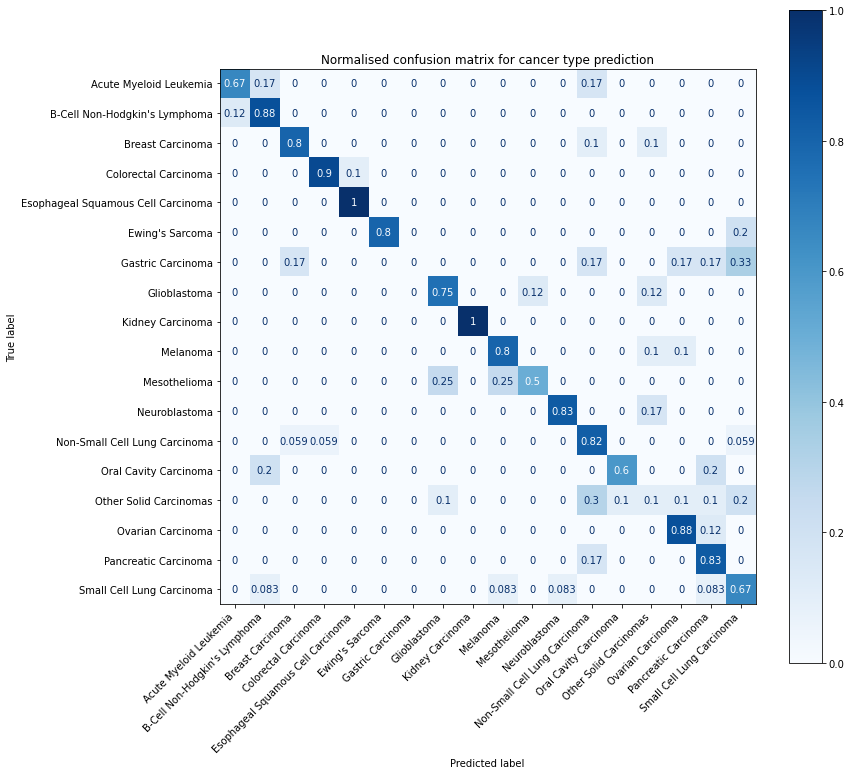

In [7]:
fig, ax = plt.subplots(1, figsize=(12, 12))
plot_confusion_matrix(clf,
                      X_test,
                      y_test,
                      cmap=plt.cm.Blues,
                      ax=ax,
                      normalize='true')
plt.xticks(rotation=45, ha='right')
plt.title("Normalised confusion matrix for cancer type prediction")

In [8]:
y_pred = clf.predict(X_test)

In [46]:
y_pred

array(['Neuroblastoma', "B-Cell Non-Hodgkin's Lymphoma",
       'Non-Small Cell Lung Carcinoma', 'Small Cell Lung Carcinoma',
       'Non-Small Cell Lung Carcinoma', 'Pancreatic Carcinoma',
       'Ovarian Carcinoma', 'Breast Carcinoma', "Ewing's Sarcoma",
       'Glioblastoma', 'Colorectal Carcinoma', 'Breast Carcinoma',
       'Small Cell Lung Carcinoma', 'Melanoma', 'Pancreatic Carcinoma',
       'Kidney Carcinoma', 'Neuroblastoma',
       'Non-Small Cell Lung Carcinoma', 'Melanoma',
       "B-Cell Non-Hodgkin's Lymphoma", 'Non-Small Cell Lung Carcinoma',
       'Breast Carcinoma', 'Acute Myeloid Leukemia',
       "B-Cell Non-Hodgkin's Lymphoma", 'Non-Small Cell Lung Carcinoma',
       'Non-Small Cell Lung Carcinoma', 'Colorectal Carcinoma',
       'Mesothelioma', 'Other Solid Carcinomas', 'Acute Myeloid Leukemia',
       'Glioblastoma', "B-Cell Non-Hodgkin's Lymphoma",
       'Breast Carcinoma', 'Non-Small Cell Lung Carcinoma', 'Melanoma',
       'Kidney Carcinoma', 'Oral Cavity Ca

In [43]:
y_conf = clf.predict_proba(X_test)

In [9]:
print(classification_report(y_test, y_pred))

                                    precision    recall  f1-score   support

            Acute Myeloid Leukemia       0.80      0.67      0.73         6
     B-Cell Non-Hodgkin's Lymphoma       0.70      0.88      0.78         8
                  Breast Carcinoma       0.80      0.80      0.80        10
              Colorectal Carcinoma       0.90      0.90      0.90        10
Esophageal Squamous Cell Carcinoma       0.83      1.00      0.91         5
                   Ewing's Sarcoma       1.00      0.80      0.89         5
                 Gastric Carcinoma       0.00      0.00      0.00         6
                      Glioblastoma       0.75      0.75      0.75         8
                  Kidney Carcinoma       1.00      1.00      1.00         6
                          Melanoma       0.80      0.80      0.80        10
                      Mesothelioma       0.67      0.50      0.57         4
                     Neuroblastoma       0.83      0.83      0.83         6
     Non-Sm

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [15]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(data_sample.iloc[:,:-2])

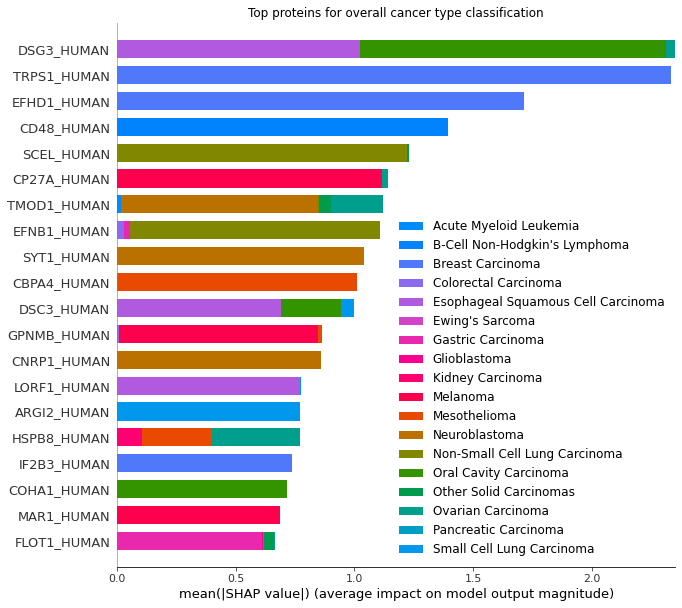

In [51]:
plt.figure(figsize=(10,10))
plt.title("Top proteins for overall cancer type classification")
shap.summary_plot(shap_values,
                  data_sample.iloc[:, :-2],
                  class_inds='original',
                  class_names=sorted(set(y)),
                  plot_size=None)

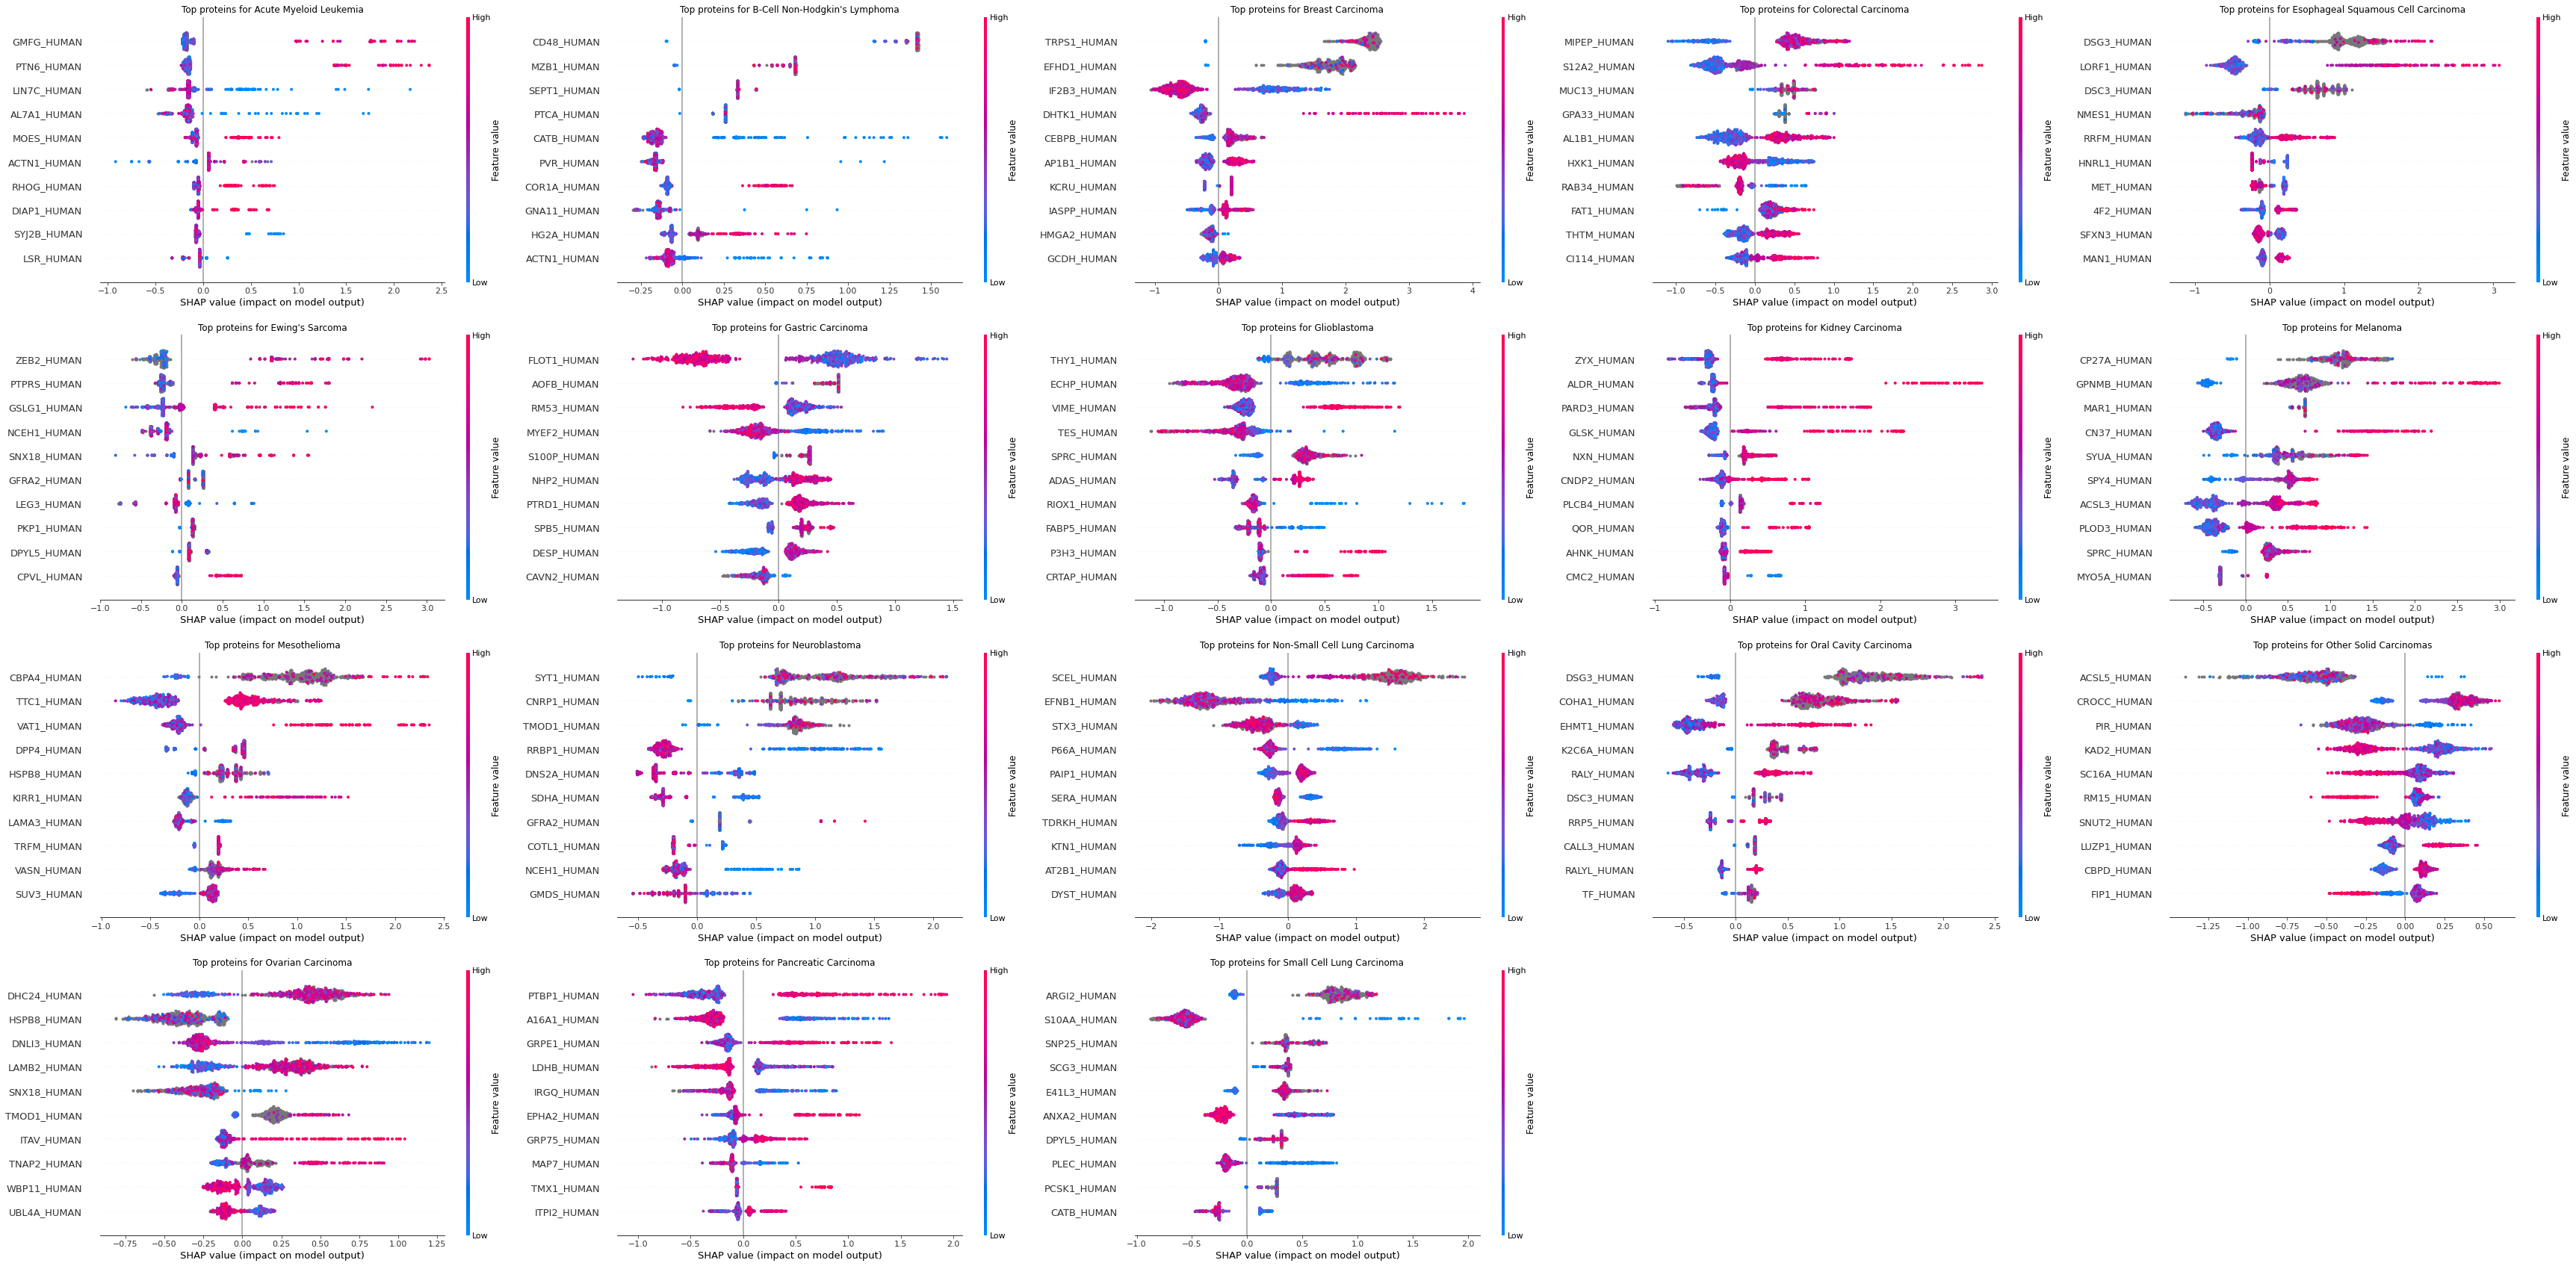

In [42]:
plt.figure(figsize=(60, 30))
for i in range(len(sorted(set(y)))):
    cancer_type = sorted(set(y))[i]
    plt.subplot(4, 5, i + 1)
    plt.title(f'Top proteins for {cancer_type}')
    shap.summary_plot(shap_values[i],
                      data_sample.iloc[:, :-2],
                      max_display=10,
                      show=False,
                      plot_size=None)
#     ax[i // 5, i % 5].figure = fig

In [29]:
[x for x in proteins if 'PSA' in x]

['PSA1_HUMAN',
 'PSA2_HUMAN',
 'PSA3_HUMAN',
 'PSA4_HUMAN',
 'PSA5_HUMAN',
 'PSA6_HUMAN',
 'PSA7_HUMAN',
 'PSA_HUMAN']